In this code i have trained segmentation model to segment tumor in breast MRI, also tumor can be either benign or malignant.

This code first merse all masks and labels, to create single mask representing tumor and its type.

Segmentation model is used to segment the tumor in Breast MRI.

In [1]:
import numpy as np # linear algebra
import os

# Dataset

## Load Classes Names

In [2]:
BASE_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
unique_classes = []
for path in os.listdir(BASE_PATH):
    unique_classes.append(path)
print(unique_classes)

['benign', 'normal', 'malignant']


## assign index to classes

In [3]:
class_index = [unique_classes[1], unique_classes[0], unique_classes[2]]
for c in class_index:
    print(c, "-", class_index.index(c))

normal - 0
benign - 1
malignant - 2


# Loading images and masks paths

because images it self take lot of space, right now we dont need images.

In [4]:
images = []
masks = []
labels = []
for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [5]:
print(len(images))

780


In [6]:
images[0]

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (2).png'

# Data Loading and Preprocessing

In [7]:
input_images_size = 256
channel = 1

In [8]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
    """ Load single image as Grayscale
    """
    # load image as grayscale
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    """ Pad images to make them square
    """
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2

    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
    """Resize mask, its different because mask pixel value can change because of resize
    """
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
    """Resize image
    """
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img
        
def preprocess(img):
    """Image preprocessing
    Normalize image
    """
    img = img/255.0
    return img

def inverse_preprocess(img):
    """Inverse of preprocessing
    """
    img = img*255
    return img

def load_data(img_path, msk_path, label):
    """Load image, mask and repalce mask value with class index
    0 = normal
    1 = benign
    2 = malignant
    """
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    label_indx = class_index.index(label)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)
    new_mask = np.zeros((input_images_size, input_images_size, 2))
    if label_indx != 0:
        new_mask[:, :, label_indx-1] = msk
#     print(np.unique(msk), label, label_indx)
    return img, new_mask

def load_batch(images, masks, labels):
    """Load Batch of data
    """
    batch_x = []
    batch_y = []
    for i, m, l in zip(images, masks, labels):
        img, msk = load_data(i, m, l)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y) 

0.0 255.0 (256, 256)


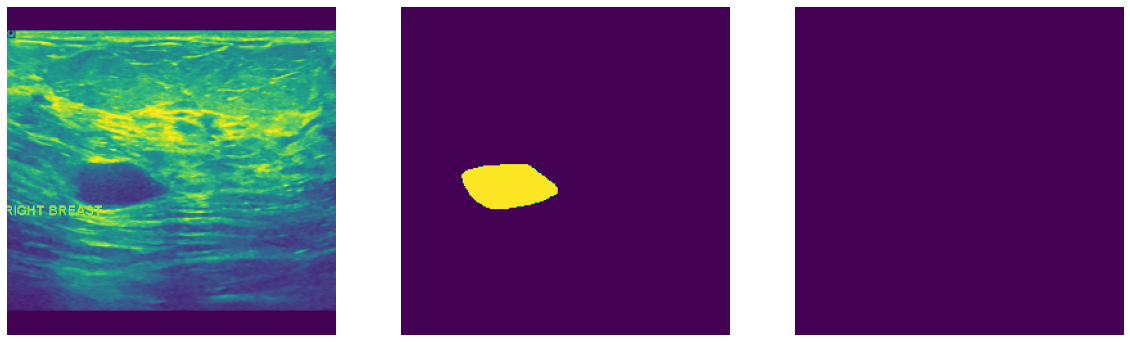

0.0 250.63671875 (256, 256)


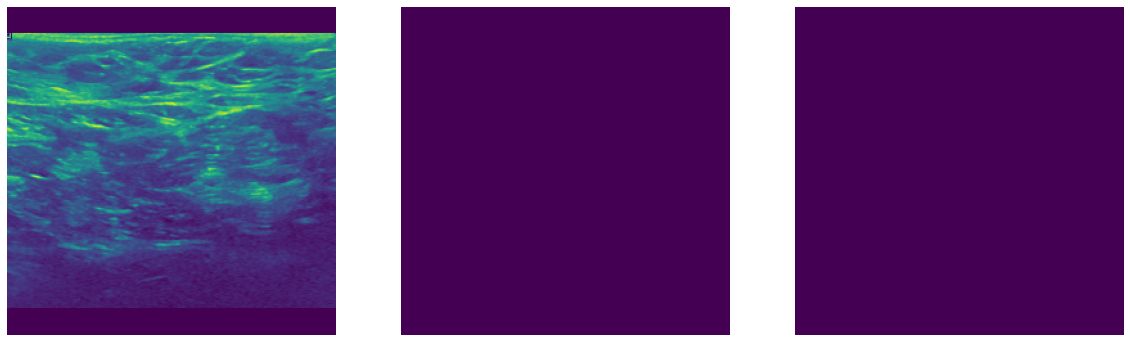

0.0 255.0 (256, 256)


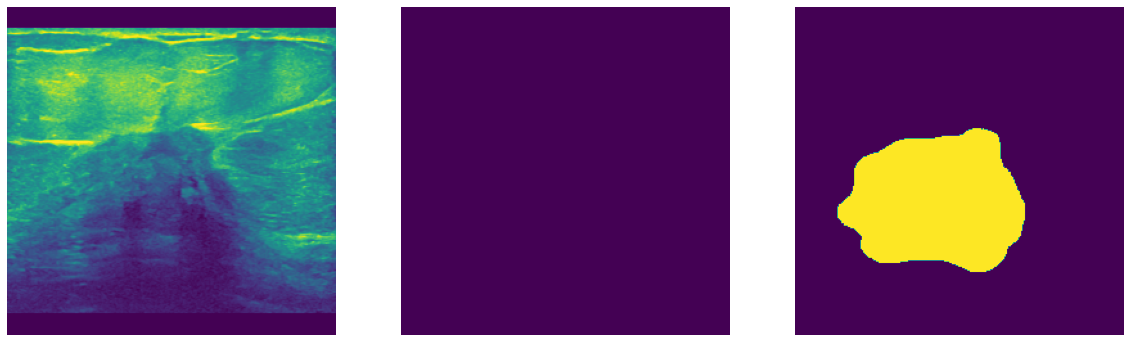

In [9]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(msk[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(msk[:, :, 1])
    plt.show()

In [10]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

# Model

In [11]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 5.2 MB/s             


In [12]:
import segmentation_models as sm
import tensorflow as tf
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
LR = 0.00001
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size,
                             input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


2022-01-08 05:24:36.815501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 05:24:36.902934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 05:24:36.903638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 05:24:36.904744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Training

In [13]:
batch_size = 4
history = {"epoch": []}
for e in range(100):
    print("epoch:",e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [],
                   "IOU": [],
                   "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = bs+batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
         "IOU", np.round(np.mean(temp_history["IOU"]), 4),
         "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)
    
model.save_weights("breast_tumor_segmentation")

epoch: 0 > 

2022-01-08 05:24:44.158817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-08 05:24:46.007470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


loss 1.0995 IOU 0.0325 F-Score 0.0592
epoch: 1 > loss 1.0402 IOU 0.0524 F-Score 0.0907
epoch: 2 > loss 1.0117 IOU 0.0868 F-Score 0.1384
epoch: 3 > loss 0.9892 IOU 0.1329 F-Score 0.194
epoch: 4 > loss 0.9687 IOU 0.1802 F-Score 0.2434
epoch: 5 > loss 0.9508 IOU 0.2176 F-Score 0.2778
epoch: 6 > loss 0.9349 IOU 0.2451 F-Score 0.3016
epoch: 7 > loss 0.9191 IOU 0.2713 F-Score 0.3228
epoch: 8 > loss 0.9037 IOU 0.29 F-Score 0.3373
epoch: 9 > loss 0.8892 IOU 0.3041 F-Score 0.3475
epoch: 10 > loss 0.8759 IOU 0.3133 F-Score 0.354
epoch: 11 > loss 0.8635 IOU 0.3218 F-Score 0.36
epoch: 12 > loss 0.8522 IOU 0.3288 F-Score 0.3651
epoch: 13 > loss 0.8418 IOU 0.3351 F-Score 0.3695
epoch: 14 > loss 0.832 IOU 0.341 F-Score 0.3735
epoch: 15 > loss 0.8222 IOU 0.3468 F-Score 0.3771
epoch: 16 > loss 0.8127 IOU 0.3526 F-Score 0.3812
epoch: 17 > loss 0.8031 IOU 0.3574 F-Score 0.3843
epoch: 18 > loss 0.7944 IOU 0.3644 F-Score 0.3896
epoch: 19 > loss 0.7865 IOU 0.3659 F-Score 0.3905
epoch: 20 > loss 0.7792 IOU 0

# Testing

0.0 255.0 (256, 256)
(256, 256)


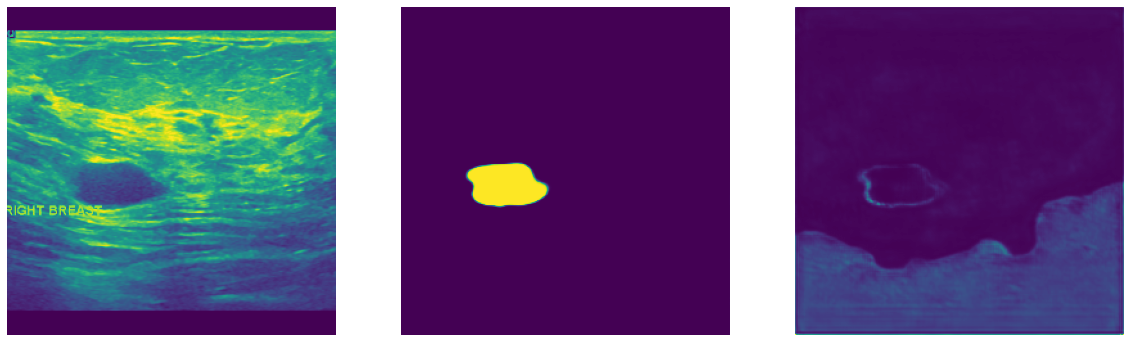

0.0 250.63671875 (256, 256)
(256, 256)


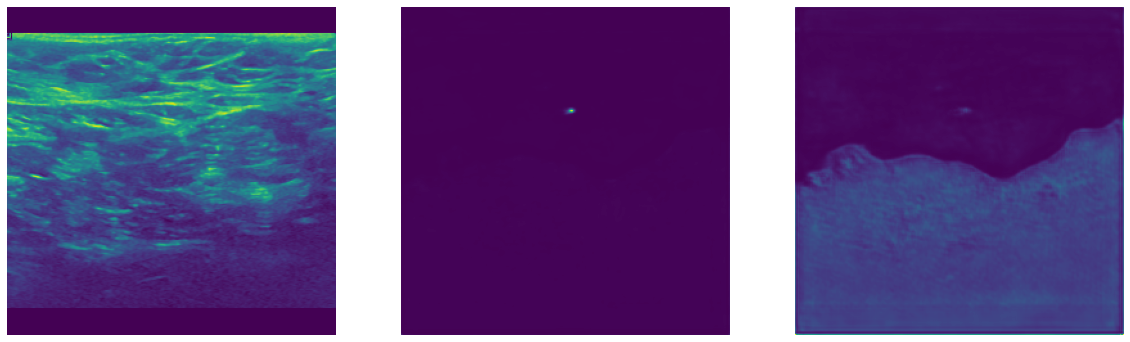

0.0 255.0 (256, 256)
(256, 256)


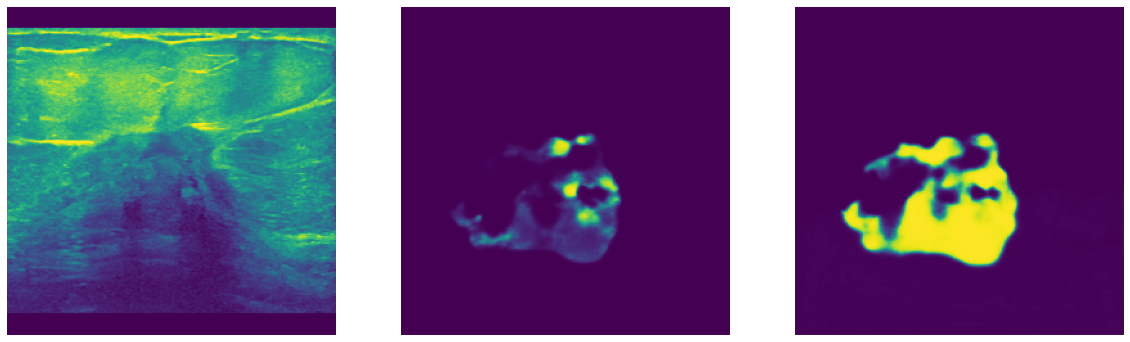

In [14]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)
    
    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(pred[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(pred[:, :, 1])
    plt.show()